<a href="https://colab.research.google.com/github/muxeres/PNL/blob/master/%5BONLINE%5D_Classifica%C3%A7%C3%A3o_de_textos_An%C3%A1lise_de_Sentimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de textos - Análise de Sentimentos
## Processamento de Linguagem Natural
Nesta aula continuaremos trabalhando com Classificação de textos, porém agora focaremos em uma tarefa específica, chamada de **Análise de Sentimentos**.

O objetivo é que ao final desta aula você:
1. Entenda o que é a **Análise de Sentimentos**
2. Saiba treinar um classificador supervisionado para realizar análise de sentimentos usando um corpus anotado
3. Aprenda a utilizar a biblioteca Polyglot do Python que já possui métodos para identificar polaridade de textos em português
4. Acesse API do Twitter para obter dados em tempo real de redes sociais




### **O que é a Análise de Sentimentos?**

É a interpretação e classificação de emoções relativas a um texto, sendo estas emoções explícitas declaradas no texto ou implícitas.

![Análise de sentimentos. Fonte: https://monkeylearn.com/sentiment-analysis/](https://docs.google.com/uc?export=download&id=1okG1oHXPhnZiBBTtpZG4b3VdaWovCndT)

É uma tarefa de PLN/Machine Learning que permite empresas identificarem os sentimentos dos consumidores em relação a produtos, marcas ou serviços, através de opiniões deixadas em redes sociais ou em canais de comunicação da empresa.


















### **Como treinar um classificador para realizar a Análise de Sentimentos?**
Iremos desenvolver nosso classificador, utilizando uma abordagem supervisionada, ou seja, precisaremos de dados rotulados com suas respectivas emoções.

O pipeline de execução é muito similar aos exemplos de classificação realizados na última semana, o que muda efetivamente são as classes/categorias envolvidas.

#### Dados
Para este exemplo iremos trabalhar com uma [base de dados de notícias](https://www.aclweb.org/anthology/W15-5616.pdf), rotulada com as emoções básicas de [Ekman](https://www.tandfonline.com/doi/abs/10.1080/02699939208411068): **alegria**, **tristeza**, **raiva**, **medo**, **repugnância** e **surpresa**. Em caso de ausência de emoção, a categoria **neutro** foi aplicada.



> **IMPORTANTE**: Faça o upload da base de dados para seu ambiente Google Colab ou Jupyter Notebook! Segue o [link](https://drive.google.com/file/d/12-mbbvHtnDVRTbQnhmOfnIXppbQ0hoyn/view?usp=sharing) para acesso.



#### Fluxo de execução
Vamos seguir o seguinte fluxo de processamento dos dados:


1.   Abrir o corpus
2.   Remover as stop-words
3.   Aplicar stemmer
4.   Gerar o Bag of Words
5.   Treinar o modelo SVM
6.   Predizer/Avaliar o modelo



In [ ]:
# Abre corpus
f = open("analise-sentimentos-2000-noticias.txt", "r", encoding="utf-8-sig")
linhas = f.readlines()

corpus_textos = []
corpus_rotulos = []

# Percorre as 2000 linhas
for linha in linhas:

  # Separa texto e rótulo/categoria/emoção
  item = linha.split(";;")

  corpus_rotulos.append(item[0])
  corpus_textos.append(item[1])

In [ ]:
# 5 primeiros textos
corpus_textos[0:5]

['irã liberta viúva condenada ao apedrejamento, diz comitê internacional. a viúva iraniana sakineh mohammadi-ashtiani, condenada à morte por apedrejamento, foi libertada juntamente com o seu filho e o seu advogado, anunciou nesta quinta-feira (9) o comitê internacional contra apedrejamento, sediado na alemanha.\n',
 'haiti sofre com cólera depois da passagem do furacão sandy. após a passagem do furacão sandy pelo haiti, o país vive as dificuldades da reconstrução, além de problemas causados pela contaminação da bactéria que causa o cólera.\n',
 'mulher acorda e encontra crocodilo de 3 m e 27 ovos no jardim de casa. especialistas capturaram e transferiram animal para local adequado.\n',
 'enchentes causam a morte de 4 pessoas em al: vítimas são mãe, filho, idosa de 100 anos e adolescente. defesa civil da capital já registrou mais de 30 ocorrências.\n',
 'sem detalhes do que será discutido, revisão do plano diretor começa na segunda (17). dez oficinas, 19 audiências públicas e canal inte

In [ ]:
# 5 primeiros rótulos
corpus_rotulos[0:5]

['alegria', 'tristeza', 'surpresa', 'tristeza', 'neutro']

Em nossos exemplos de classificação anteriores, separamos parte do banco de dados para **TREINAMENTO** e outra parte para **TESTE**, nesse tipo de avaliação que chamamos de **hold-out**.

Existem outras formas de realizar a avaliação, inclusive mais indicadas de acordo com a situação, mas isto não está no escopo de nossa disciplina, caso queira saber mais métodos de avaliação como o **cross-validation**, leia [este post](https://medium.com/@eijaz/holdout-vs-cross-validation-in-machine-learning-7637112d3f8f).

In [ ]:
from sklearn.model_selection import train_test_split

# O próprio sklearn tem um método para dividir a base de dados em treinamento e teste
# Neste caso estamos deixando 90% para treinamento e 10% para testes
corpus_treinamento, corpus_teste, rotulos_treinamento, rotulos_teste = train_test_split(corpus_textos, corpus_rotulos, test_size=0.10, random_state=42)

In [ ]:
len(corpus_treinamento)

1800

In [ ]:
len(corpus_teste)

200

In [ ]:
len(rotulos_treinamento)

1800

In [ ]:
len(rotulos_teste)

200

Vamos deixar preparada uma função para pré-processar os textos, utilizando uma lista de stop-words com novos itens, o stemming e normalização dos textos.

In [ ]:
import nltk
from nltk import tokenize
nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt')

stopwords = nltk.corpus.stopwords.words('portuguese') #carrega stopwords da lingua portuguesa disponíveis no NLTK
stopwords += (',','.','(',')','"',"'",'´','`','!','$','%','&','...','-',':',';','?','``','\'\'') #acrescenta simbolos
stopwords += ('a','e','i','o','u','A','E','I','O','U') #acrescenta também vogais

stemmer = nltk.stem.RSLPStemmer()

def my_preprocessor(text):

    # Normaliza para minúsculas
    text=text.lower()

    # Tokeniza
    words = tokenize.word_tokenize(text, language='portuguese')
    # Remove stop-words
    words_no_stopwords = [word for word in words if not word in stopwords]
    # Aplica stemming
    stemmed_words=[stemmer.stem(word=word) for word in words_no_stopwords]
    return ' '.join(stemmed_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Agora vamos extrair os atributos do texto (gerar a representação vetorial - bag of words) e criar nosso pipeline de classificação usando o classificador SVM.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer

# Primeiro aplica o BoW, depois envia dados ao classificador SVM
# (SEM retirada de stop-words e stemming)
sent_clf = Pipeline([('vect', CountVectorizer()),('clf', SVC(kernel='linear', C=1))])

# Depois de executar uma vez, verifique os resultados e compare-os depois de descomentar a linha abaixo, onde retiramos as stop-words e aplicamos stemming
# (COM retirada de stop-words e stemming)
#sent_clf = Pipeline([('vect', CountVectorizer(preprocessor = my_preprocessor)),('clf', SVC(kernel='linear', C=1))])

In [ ]:
# Inicia treinamento
sent_clf = sent_clf.fit(corpus_treinamento, rotulos_treinamento)

Já temos nosso modelo treinado! Agora vamos predizer a base de teste e avaliar os resultados.

In [ ]:
# Prediz base de teste
rotulos_preditos = sent_clf.predict(corpus_teste)

In [ ]:
from sklearn.metrics import classification_report

# Mostra relatório completo de avaliação
print(classification_report(rotulos_teste, rotulos_preditos))

              precision    recall  f1-score   support

     alegria       0.00      0.00      0.00        19
    desgosto       0.44      0.26      0.33        27
        medo       0.32      0.39      0.35        18
      neutro       0.52      0.73      0.61        51
       raiva       0.29      0.29      0.29         7
    surpresa       0.42      0.47      0.44        32
    tristeza       0.66      0.59      0.62        46

    accuracy                           0.48       200
   macro avg       0.38      0.39      0.38       200
weighted avg       0.45      0.47      0.45       200



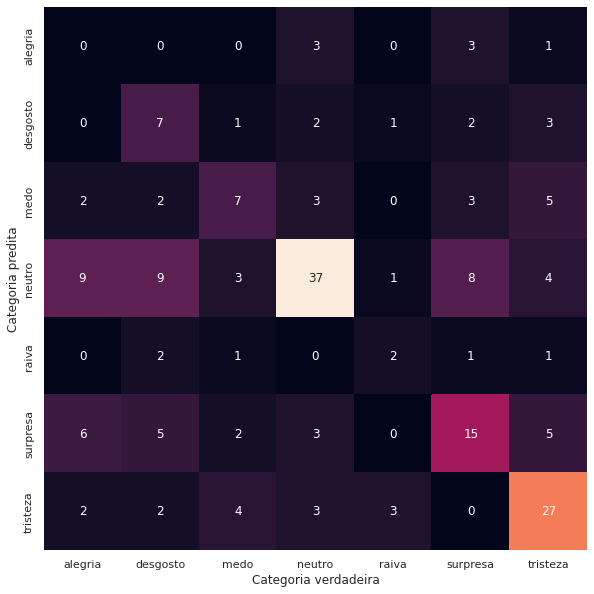

In [ ]:
from sklearn.metrics import confusion_matrix

# Podemos imprimir a matriz de confusão para tentar entender melhor os resultados
mat = confusion_matrix(rotulos_teste, rotulos_preditos)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

rotulos_nomes = ['alegria', 'desgosto', 'medo', 'neutro', 'raiva', 'surpresa', 'tristeza']

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=rotulos_nomes, yticklabels=rotulos_nomes )
plt.xlabel('Categoria verdadeira')
plt.ylabel('Categoria predita');

> **CONCLUSÃO**: Apesar de verificarmos melhoria ao pré-processarmos o texto, os resultados ainda são regulares.

#### **Atividade Somativa 2 - Como podemos tentar melhorar os resultados?**

**1) Redução da granularidade dos sentimentos**
Como podemos ver na matriz de confusão o classificador tem vários pontos de erro, em todas emoções. E se modificarmos o corpus para ao invés de 7 emoções, trabalhar com as 3 clássicas (positivo, neutro, negativo)?

Vamos então adotar a seguinte sistemática de atualização da base de dados:

A classe "**positivo**" será obtida utilizando-se as instâncias da base original rotuladas como "alegria".

A classe "**negativo**" será obtida utilizando-se as instâncias rotuladas como "raiva", "medo", "desgosto" e "tristeza".

Já a classe "**neutro**", utilizará as instâncias da base original rotuladas como "neutro".

As instâncias rotuladas como "surpresa" não serão utilizadas.

Crie um novo arquivo para esta base de dados atualizada, carregue-o em nosso notebook e compare os resultados.

**2) Configuração dos parâmetros de extração de atributos e do classificador**
Altere a configuração de pelo menos um atributo gerado pela vetorização das palavras (i.e., CountVectorizer) e também pelo classificador utilizado.

**3) Adicione novas etapas de extração de atributos ou de pré-processamento**
Incorpore ao menos uma nova etapa de pré-processamento ou extração de atributos (e.g., TF-IDF) ao pipeline atual.

**4) Utilize outro classificador de texto**
Treine ao menos um novo modelo utilizando um classificador de textos diferentes. Ele pode pertencer à biblbioteca sklearn ou qualquer outra.



### **Existe alguma ferramenta pronta que realize análise de sentimentos?**
Não é sempre que teremos um corpus anotado para utilizar em nossas tarefas, neste caso, existem bibliotecas que incorporam funcionalidades simples que podem ser usadas para detectar a polaridade de textos (negativo, positivo).

No caso da língua portuguesa, a [Polyglot](https://polyglot.readthedocs.io/en/latest/index.html) tem um léxico de polaridade das palavras, que pode ser usado para detecção simples de sentimentos.

In [ ]:
# Ela tem algumas dependências que devem ser instaladas
!pip install -U git+https://github.com/aboSamoor/polyglot.git@master

  Cloning https://github.com/aboSamoor/polyglot.git (to revision master) to /tmp/pip-req-build-4pq72zya
  Running command git clone -q https://github.com/aboSamoor/polyglot.git /tmp/pip-req-build-4pq72zya
     |████████████████████████████████| 41.4 MB 1.3 MB/s 
     |████████████████████████████████| 304 kB 42.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for polyglot: filename=polyglot-16.7.4-py2.py3-none-any.whl size=70672 sha256=9ee59927a028b32f03ae61dab341070cc0326ff80b380d691ac7e3707973012c
  Stored in directory: /tmp/pip-ephem-wheel-cache-_udesxuf/wheels/6d/b6/83/526ac20beb2e8b06c33aea6ac5edf6a07d3de55011bcc35ee8
  Created wheel for pycld2: filename=pycld2-0.41-cp37-cp37m-linux_x86_64.whl size=9834200 sha256=8f36bdbe8efc362ef0076bd7c7098c2eb03161d80683d3e7df723c0f7c516389
  Stored in directory: /root/.cache/pip/wheels/ed/e4/58/ed2e9f43c07d617cc81fe7aff0fc6e42b16c9cf6afe960b614

In [ ]:
import polyglot
from polyglot.text import Text
# Baixa o léxicos da lingua portuguesa
!polyglot download LANG:pt

[polyglot_data] Downloading collection 'LANG:pt'
[polyglot_data]    | 
[polyglot_data]    | Downloading package sgns2.pt to
[polyglot_data]    |     /root/polyglot_data...
[polyglot_data]    | Downloading package unipos.pt to
[polyglot_data]    |     /root/polyglot_data...
[polyglot_data]    | Downloading package ner2.pt to
[polyglot_data]    |     /root/polyglot_data...
[polyglot_data]    | Downloading package counts2.pt to
[polyglot_data]    |     /root/polyglot_data...
[polyglot_data]    | Downloading package transliteration2.pt to
[polyglot_data]    |     /root/polyglot_data...
[polyglot_data]    | Downloading package embeddings2.pt to
[polyglot_data]    |     /root/polyglot_data...
[polyglot_data]    | Downloading package uniemb.pt to
[polyglot_data]    |     /root/polyglot_data...
[polyglot_data]    | Downloading package pos2.pt to
[polyglot_data]    |     /root/polyglot_data...
[polyglot_data]    | Downloading package sentiment2.pt to
[polyglot_data]    |     /root/polyglot_data

In [ ]:
text = Text("O filme que vimos é realmente muito bom!")
print("{:<16}{}".format("Word", "Polarity")+"\n"+"-"*30)
for w in text.words:
    print("{:<16}{:>2}".format(w, w.polarity))

Word            Polarity
------------------------------
O                0
filme            0
que              0
vimos            0
é                0
realmente        0
muito            1
bom              1
!                0


In [ ]:
text = Text("As notas foram ruins.")
print("{:<16}{}".format("Word", "Polarity")+"\n"+"-"*30)
for w in text.words:
    print("{:<16}{:>2}".format(w, w.polarity))

Word            Polarity
------------------------------
As               0
notas            0
foram            0
ruins           -1
.                0


In [ ]:
text = Text("Não sei o que pensar.")
print("{:<16}{}".format("Word", "Polarity")+"\n"+"-"*30)
for w in text.words:
    print("{:<16}{:>2}".format(w, w.polarity))

Word            Polarity
------------------------------
Não              0
sei              0
o                0
que              0
pensar           0
.                0


### **Como obter dados em tempo real de redes sociais?**
Já vimos na disciplina que é possível utilizar o web-scraping para obter páginas da web e percorrer a estrutura HTML em busca das informações. Porém, em alguns casos temos opções mais rápidas e viáveis para recolher dados. Alguns sites oferecem o serviço de [API](https://canaltech.com.br/software/o-que-e-api/) para acesso aos dados, onde podemos autenticar e utilizar funções para buscar dados em tempo real.

Em nosso exemplo, utilizaremos a [API do Twitter](https://developer.twitter.com/en/docs) para buscar tweets sobre determinado assunto.

Neste exemplo, utilizaremos as chaves de acesso da conta do professor, mas quando você for desenvolver seu script, você deve criar seu próprio token de acesso. Basta acessar sua conta no Twitter, na [página do desenvolvedor](https://developer.twitter.com/en/docs) você deve ir em Apps > Create an app.


In [ ]:
import tweepy
from tweepy import OAuthHandler

# As chaves e tokens que você receberá ao criar um App
consumer_key = 'iUpbJiOv2LGFZdRTSqOOFndf7'
consumer_secret = 'AVQQS4UcSI6dlRkwO3PdrNo6Iuwl9k5yE4oae18yNvACnhREzs'
access_token = '12948382-GTwHQSlj2ylAsMxsm2TT8ecYQ8fUteAfNGTqJutAP'
access_token_secret = 'U1HOAmQWkSwfiGEacEqDL59QZ8dvpBhG03yiusjyhtI2M'

api = None
try:
  # Cria um objeto de autenticação (OAuthHandler)
  auth = OAuthHandler(consumer_key, consumer_secret)
  # Define o token e senha de acesso
  auth.set_access_token(access_token, access_token_secret)
  # Cria um novo objeto API para acessar os tweets
  api = tweepy.API(auth)
except:
  print("Erro: Falha de autenticação no Twitter")

Uma vez que temos um objeto API autenticado, podemos fazer nossas buscas. A API oferecer vários métodos e parâmetros para buscar dados, basta olhar na [documentação da biblioteca tweepy](http://docs.tweepy.org/en/v3.5.0/api.html). Nós iremos utilizar o método **search()**, que funciona de maneira similar a própria caixa de busca no site do Twitter.

In [ ]:
try:

  # Busca até 200 tweets utilizando a query informada
  tweets = api.search(q = 'Bolsonaro', count = 200)

except tweepy.TweepError as e:
  print("Erro : " + str(e))



> **DICA**: Estamos colocando todos trechos do processo entre [blocos try/except](https://docs.python.org/pt-br/3.8/tutorial/errors.html), assim em caso de erro, temos certeza de qual ponto do processo está com problemas.



Vamos fazer uma função que através da pontuação de polaridade das palavras do tweet, obtido através do léxico do polyglot, calculamos a polaridade do texto. Utilizaremos uma fórmula bem simples, onde somaremos todas polaridades, se o resultado por positivo o sentimento é positivo, se for zero é neutro, caso menor que zero, negativo.

In [ ]:
qtdeTweetsPos = 0
qtdeTweetsNeg = 0
qtdeTweetsNeu = 0
tweets_str_list = []

# Percorre os tweets encontrados
for tweet in tweets:

  #ATENÇÃO: Tenha certeza que já instalou e importou o polyglot acima!
  text = Text(tweet.text)

  somaP = 0

  # Percorre as palavras do tweet
  for palavra in text.words:
    # Soma polaridade da palavra
    somaP += palavra.polarity

  # Faz contagem das polaridades
  if somaP > 0:
    qtdeTweetsPos += 1
  elif somaP < 0:
    qtdeTweetsNeg += 1
  else:
    qtdeTweetsNeu += 1

  # Imprime o tweet
  print("Polaridade: " + str(somaP) + " >>> " + tweet.text + "\n")

  tweets_str_list.append(tweet.text)

Polaridade: -1 >>> RT @carmelonetobr: Lula disse que "a única eleição roubada no Brasil foi a de Bolsonaro". O TSE não irá investigá-lo por isso?

Polaridade: 0 >>> RT @AfpChecamos: ➕ Uma busca pelo termo inscrito na parte da frente do trem, “CBTU”, junto com “inauguração” e “Bolsonaro”, que acena para…

Polaridade: -2 >>> Técnico Rafael Soriano agride bandeirinha. Tenho ódio e nojo de homem que não respeita e agride a Mulher: essa é um… https://t.co/XI4wjHr48W

Polaridade: -1 >>> RT @carmelonetobr: Lula disse que "a única eleição roubada no Brasil foi a de Bolsonaro". O TSE não irá investigá-lo por isso?

Polaridade: -1 >>> RT @Rconstantino: Adoro quando eles confessam o crime! Então quer dizer que podemos colocar a CULPA DO LOCKDOWN anticientífico que destruiu…

Polaridade: -2 >>> RT @guimaraes13PT: Bolsonaro envergonha as famílias brasileiras! A corrupção envolvendo pastores no MEC é um triste episódio da vida públic…

Polaridade: 0 >>> RT @verinhabombard1: ATENÇÃO BOLSONARISTAS DA 

ValueError: ignored

> **ATENÇÃO:** As vezes, o polyglot pode identificar de maneira errada o idioma do tweet, e neste caso tentará utilizar um recurso léxico que ainda não foi baixado. Você pode corrigir de duas maneiras, ou usa o try/except e ignora este tweet, ou baixa o léxico dos idiomas envolvidos e deixa que ele calcule de maneira errada mesmo.

In [ ]:
# Você pode fazer download dos léxicos de sentimento de cada idioma separadamente
!polyglot download sentiment2.en
!polyglot download sentiment2.tr
!polyglot download sentiment2.es

In [ ]:
# Agora calculamos as porcentagens
print("POSITIVOS: {}%".format(100*qtdeTweetsPos/len(tweets)))
print("NEGATIVOS: {}%".format(100*qtdeTweetsNeg/len(tweets)))
print("NEUTROS: {}%".format(100*qtdeTweetsNeu/len(tweets)))

In [ ]:
import matplotlib.pyplot as plt

# Podemos plotar um gráfico também
fig=plt.figure(figsize=(6,6))
plt.pie([qtdeTweetsPos, qtdeTweetsNeg, qtdeTweetsNeu],labels=['Positivo', 'Negativo', 'Neutro'],colors=['green', 'red', 'blue'])
plt.ylabel('')
plt.title('Polaridade',fontsize='18')
plt.show()

Poderíamos também construir uma WordCloud para entender melhor quais as palavras que estão mais associadas ao tema buscado.

Para isso iremos remover as stop-words e chamar uma função de WordCloud.

In [ ]:
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
from wordcloud import WordCloud

stopword= nltk.corpus.stopwords.words('portuguese')

# Retiramos ocorrências de links e retweets
stopword.append('https')
stopword.append('RT')
stopword.append('co')

# Cria uma única string com todos tweets
str_tweets = " ".join(tweets_str_list)

# Gera a wordcloud
wordcloud = WordCloud(max_words=2000, max_font_size=90, stopwords=stopword, height=400, width=800).generate(str_tweets)

fig = plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('WordCloud Twitter', fontsize='18')
plt.show()


#### Considerações finais
Aqui utilizamos uma abordagem BEM simples, baseada em um léxico de polaridade da biblioteca polyglot. Os textos provindos de redes sociais são muito difíceis de processar, o ideal seria uma abordagem mais complexa, de preferência com aprendizado supervisionado, capaz de lidar com algumas características e desafios destes textos:
- Uso de gírias
- Ausência de regras ortográficas
- Uso de símbolos (emojis, hashtags)
- Presença de ironia
- Uso de hiperlinks
- entre outros

#### **Atividade complementar**
Você pode deixar o algoritmo mais robusto, ao treinar um classificador utilizando as bases rotuladas de tweets em português, listadas nas referências deste notebook.

## Referências e Material complementar

* [Portuguese Tweets for Sentiment Analysis - Corpus anotado](https://www.kaggle.com/augustop/portuguese-tweets-for-sentiment-analysis)
* [Portuguese Tweets for Sentiment Analysis using nltk and sklearn](https://www.kaggle.com/leonardoassis/portuguese-tweets-nltk-and-sklearn)
* [tweetSentBR - Corpus anotado](https://bitbucket.org/HBrum/tweetsentbr/src/master/)
* [Anotando um Corpus de Notícias para a Análise de Sentimento: um Relato de Experiência](https://www.aclweb.org/anthology/W15-5616.pdf)
* [Twitter Sentiment Analysis using NLTK, Python](https://towardsdatascience.com/twitter-sentiment-analysis-classification-using-nltk-python-fa912578614c)
* [Creating The Twitter Sentiment Analysis Program in Python with Naive Bayes Classification](https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed)
* [Sentiment Analysis with Python (Part 1) - Classifying IMDb Movie Reviews](https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184)
* [Twitter Developer API](https://developer.twitter.com/en/docs)
* [Sentiment Classification using Word Embeddings (Word2Vec)](https://medium.com/swlh/sentiment-classification-using-word-embeddings-word2vec-aedf28fbb8ca)
* [Sentiment Analysis on Tweets in Portuguese - Transformer and BERT](https://www.kaggle.com/viniciuscleves/sentiment-analysis-on-tweets-in-portuguese)

Esta aula foi inspirada no trabalho do [Prof. Emerson Cabrera Paraiso](http://lattes.cnpq.br/3493899263715892), a quem agradecemos pela permissão de uso de sua [base de dados](https://www.aclweb.org/anthology/W15-5616.pdf).

Este notebook foi produzido por Prof. [Lucas Oliveira](http://lattes.cnpq.br/3611246009892500).